In [1]:
library(reticulate)
use_condaenv(condaenv="pyr2", conda="/data8t_0/hms/anaconda3/bin/conda")
# use_python("/data8t_0/hms/anaconda3/envs/pyr2/bin/python")
# umap<-import('umap')

In [2]:
library(Seurat)
library(data.table)
library(ggplot2)
library(flexclust)
suppressMessages(suppressWarnings(library(stringr)))
suppressMessages(suppressWarnings(library(dplyr)))
datasetName = "Muscle_Muscle_HCLFetalMuscle1"
dataFormat = 'tsv'
setwd(paste0("/stor/public/hcad/db_v1/",datasetName,"/"))

Loading required package: grid

Loading required package: lattice

Loading required package: modeltools

Loading required package: stats4



In [3]:
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- read.table(paste0(datasetName,"_expression.txt.gz"),h = T,sep=',',row.names = 1)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tsv.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
# data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.csv"), h = T, sep = ",", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}

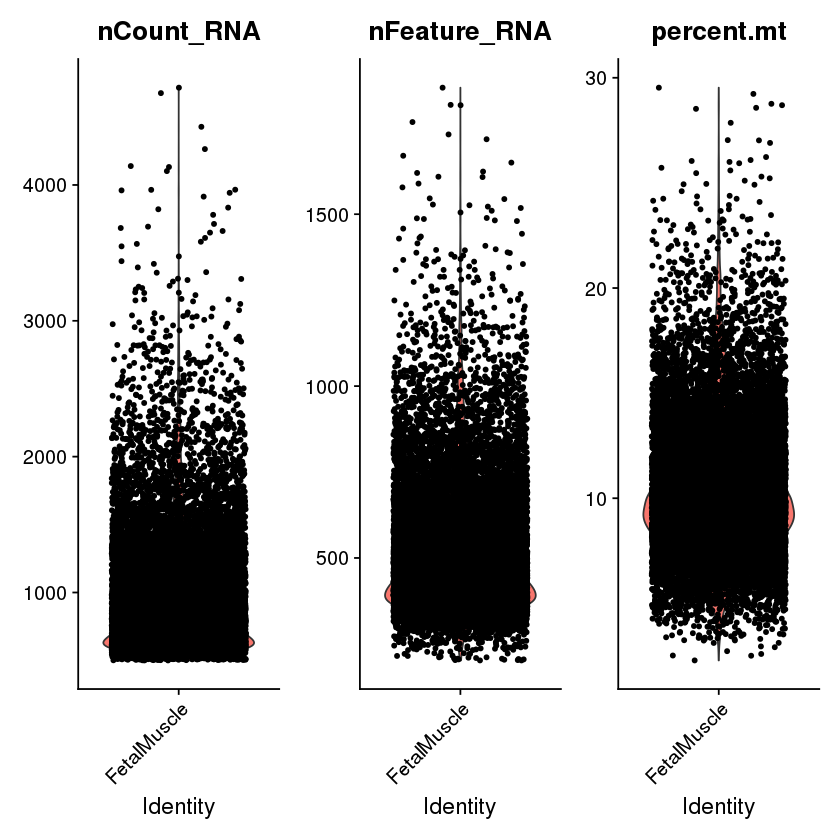

In [4]:
# Pre-processing
min.features = 20
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.features = min.features, meta.data = data.annotation)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)

if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
VlnPlot(object = dataobj, features= c("nCount_RNA","nFeature_RNA","percent.mt"))

In [5]:
percent.mt.thre = 25
nFeature_RNA_range = c(min.features, 1500)
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)

In [6]:
warnings('off')
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)

In [7]:
# *--------------------Load reference table--------------------*
print("=========Loading Reference Table=========")
ref_table_raw <- read.csv("/data8t_0/hms/workspace/HCA-d/Rtoolkit_GeneSymbolUniform/GeneSymbolRef_SelectAll_upd0731.csv", header=TRUE, na.strings=TRUE, stringsAsFactors=FALSE)
# print(dim(ref_table_raw))
print("Finished")
# *--------------------Load total gene list--------------------*
print("=========Processing Gene List=========")
total_gene_list_raw = read.table("/data8t_0/hms/workspace/HCA-d/Rtoolkit_GeneSymbolUniform/total_gene_list_43878.txt", 
                                 header=TRUE, sep='\t', fill=TRUE, stringsAsFactors=FALSE)
total_gene_list = total_gene_list_raw[,1]
# Seurat changes all "_" to "-".
total_gene_list <- str_replace(total_gene_list, "_", "-")
print("The length of gene list is: ")
print(length(total_gene_list))
print("Finished")
print("=========Processing Reference Table=========")
# Separate dataframe to previous and alias symbol sub-dataframe
# Remove duplicates and empty values
ref_table_raw <- ref_table_raw[,c("Approved.symbol","Alias.symbol","Previous.symbol")]
ref_table <- ref_table_raw[ref_table_raw[,"Previous.symbol"]!="" | ref_table_raw[,"Alias.symbol"]!="",]
# Seurat changes all "_" to "-".
ref_table$Previous.symbol <- str_replace(ref_table$Previous.symbol, "_", "-")
ref_table$Alias.symbol <- str_replace(ref_table$Alias.symbol, "_", "-")
ref_table$Approved.symbol <- str_replace(ref_table$Approved.symbol, "_", "-")
# print(dim(ref_table))
ref_table_prev <- unique(ref_table[,c("Approved.symbol","Previous.symbol")])
ref_table_prev <- ref_table_prev[ref_table_prev[,"Previous.symbol"]!="",]
ref_table_alia <- unique(ref_table[,c("Approved.symbol","Alias.symbol")])
ref_table_alia <- ref_table_alia[ref_table_alia[,"Alias.symbol"]!="",]
# print(dim(ref_table_prev))
# print(dim(ref_table_alia))
print("Finished")

# *--------------------Load query data--------------------*
print("=========Loading Query Data=========")
query_data <- as.data.frame(as.matrix(dataobj@assays$RNA@data))
query_gene_list <- rownames(dataobj)
print("The shape of query data is: ")
print(dim(query_data))
print("Print out first 5 genes in query data, in case something wrong happens in data loading: ")
print(query_gene_list[1:5])
print("Finished")

# *--------------------Perform gene name uniform--------------------*
print("=========Performing Gene Symbol Uniform=========")
print("Performing gene symbol uniform, this step may take several minutes")
gene_appearance_list <- data.frame(gene_name=total_gene_list, appearance=rep(FALSE, length(total_gene_list)))
outlier_gene_list <- c()

result_data <- query_data
result_data$genenames <- rownames(result_data)
report <- data.frame(Original.Name=character(), Modified.Name=character(), Status=character(), stringsAsFactors=FALSE)

for (i in c(1:length(query_gene_list))){
  gene_name <- query_gene_list[i]
  # Modify gene symbols, both "Alias symbol" and "Previous symbol" are used. 
  if(sum(ref_table_prev["Previous.symbol"]==gene_name)>0){
    # Multiple names matched
    if(sum(ref_table_prev["Previous.symbol"]==gene_name)>1){
      candidate_names <- paste(ref_table_prev[ref_table_prev[,"Previous.symbol"]==gene_name,"Approved.symbol"], collapse='|')
      report[i,] <- c(gene_name, candidate_names, "Multiple Candidates")
      if(gene_name %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, gene_name)
      }
    }
    # Only one name matched
    else{
      candidate_names <- ref_table_prev[ref_table_prev[,"Previous.symbol"]==gene_name,"Approved.symbol"]
      result_data[i:dim(result_data)[1],"genenames"][result_data[i:dim(result_data)[1],"genenames"]==gene_name] <- candidate_names
      report[i,] <- c(gene_name, candidate_names, "Changed")
      if(candidate_names %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==candidate_names,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, candidate_names)
      }
    }
  }
    
  else if(sum(ref_table_alia["Alias.symbol"]==gene_name)>0){
    # Multiple names matched
    if(sum(ref_table_alia["Alias.symbol"]==gene_name)>1){
      candidate_names <- paste(ref_table_alia[ref_table_alia[,"Alias.symbol"]==gene_name,"Approved.symbol"], collapse='|')
      report[i,] <- c(gene_name, candidate_names, "Multiple Candidates")
      if(gene_name %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, gene_name)
      }
    }
    # Only one name matched
    else{
      candidate_names <- ref_table_alia[ref_table_alia[,"Alias.symbol"]==gene_name,"Approved.symbol"]
      result_data[i:dim(result_data)[1],"genenames"][result_data[i:dim(result_data)[1],"genenames"]==gene_name] <- candidate_names
      report[i,] <- c(gene_name, candidate_names, "Changed")
      if(candidate_names %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==candidate_names,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, candidate_names)
      }
    }
  }
  
  # Gene name not found
  else{
    report[i,] <- c(gene_name, gene_name, "No Change")
    if(gene_name %in% total_gene_list){
      gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
    }
    else{
      outlier_gene_list <- c(outlier_gene_list, gene_name)
    }
  }
}
print("Finished")

# *--------------------Construct uniform output--------------------*
print("=========Building Output Matrix=========")
result_data_grouped <- result_data %>% group_by(genenames) %>% summarise_at(vars(-group_cols()), mean)
result_data_sub <- as.data.frame(result_data_grouped)[which(!result_data_grouped$genenames %in% outlier_gene_list),]
result_data_out <- subset(result_data_sub, select = -genenames )
rownames(result_data_out) <- result_data_sub$genenames
print("Shape of processed query data: ")
print(dim(result_data_out))

add_df <- data.frame(matrix(nrow=sum(gene_appearance_list$appearance==FALSE),ncol=dim(result_data)[2]-1, 0))
rownames(add_df) <- gene_appearance_list$gene_name[!gene_appearance_list$appearance]
colnames(add_df) <- colnames(result_data_out)

result_data_out <- rbind(result_data_out, add_df)
print("Shape of output data after adding zero-value genes. It should have 43878 genes with cell number unchanged.")
print(dim(result_data_out))
print("Finished")

[1] "=========Loading Reference Table========="
[1] "Finished"
[1] "=========Processing Gene List========="
[1] "The length of gene list is: "
[1] 43878
[1] "Finished"
[1] "=========Processing Reference Table========="
[1] "Finished"
[1] "=========Loading Query Data========="
[1] "The shape of query data is: "
[1] 19868 18302
[1] "Print out first 5 genes in query data, in case something wrong happens in data loading: "
[1] "A1BG-AS1" "A2M"      "A2M-AS1"  "A4GALT"   "AAAS"    
[1] "Finished"
[1] "=========Performing Gene Symbol Uniform========="
[1] "Performing gene symbol uniform, this step may take several minutes"
[1] "Finished"
[1] "=========Building Output Matrix========="
[1] "Shape of processed query data: "
[1] 16536 18302
[1] "Shape of output data after adding zero-value genes. It should have 43878 genes with cell number unchanged."
[1] 43878 18302
[1] "Finished"


In [8]:
dataobj <- CreateSeuratObject(result_data_out,meta.data = data.annotation)
dataobj <- FindVariableFeatures(dataobj) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))

Warning message in CreateSeuratObject(result_data_out, meta.data = data.annotation):
“Some cells in meta.data not present in provided counts matrix.”
Centering and scaling data matrix



PC_ 1 
Positive:  RPS17, PFN1, HSPB1, STMN1, H2AZ1, RPL36, PTMA, MYOG, CAV1, RPL23A 
	   HMGB2, RPS5, RPL27, HMGB1, GAPDH, RPL26, ACTC1, PCLAF, CD82, FABP5P1 
	   CHRNA1, CFL1, RPL18A, RAN, NDUFA4, RPL39, ATP5MC2, A2M, MSTN, RPL10A 
Negative:  COL1A1, COL3A1, COL1A2, POSTN, DCN, COL5A2, OGN, ITM2A, COL5A1, FSTL1 
	   LUM, COL12A1, FNDC1, DLK1, ISLR, ASPN, COL6A1, MFAP5, FN1, MEST 
	   COL6A2, VIM, PLAC9, AHNAK, CCN3, KCTD12, COL6A3, FBN1, PCOLCE, MGP 
PC_ 2 
Positive:  A2M, CAV1, TMSB4X, B2M, PECAM1, FABP4, CDH5, ESAM, GNG11, RAMP2 
	   PCAT19, CLDN5, IGFBP7, ECSCR, TUBA1B, CD93, ANXA2, APLNR, ACTB, GMFG 
	   CAVIN2, CALM1, TM4SF1, S100A11, TCIM, S100A10, COL4A1, DEPP1, CD34, CLIC1 
Negative:  MYOG, ACTC1, HBG1, HBB, TNNT2, HBA2, HBA1, HBG2, CD82, MRLN 
	   ALAS2, AHSP, FITM1, CHRNA1, TNNI1, KLHL41, KRT40, CHRND, C1QTNF3, CKB 
	   GAS5, SEPTIN4, TNNI2, NPY, SLC25A37, RPL36, RPL12, GYPB, GYPA, HBZ 
PC_ 3 
Positive:  HMGB2, LGALS1, LUM, RPL23A, DCN, PCLAF, ITM2A, TUBA1B, PTTG1, UBE2C 
	 

png 
  2

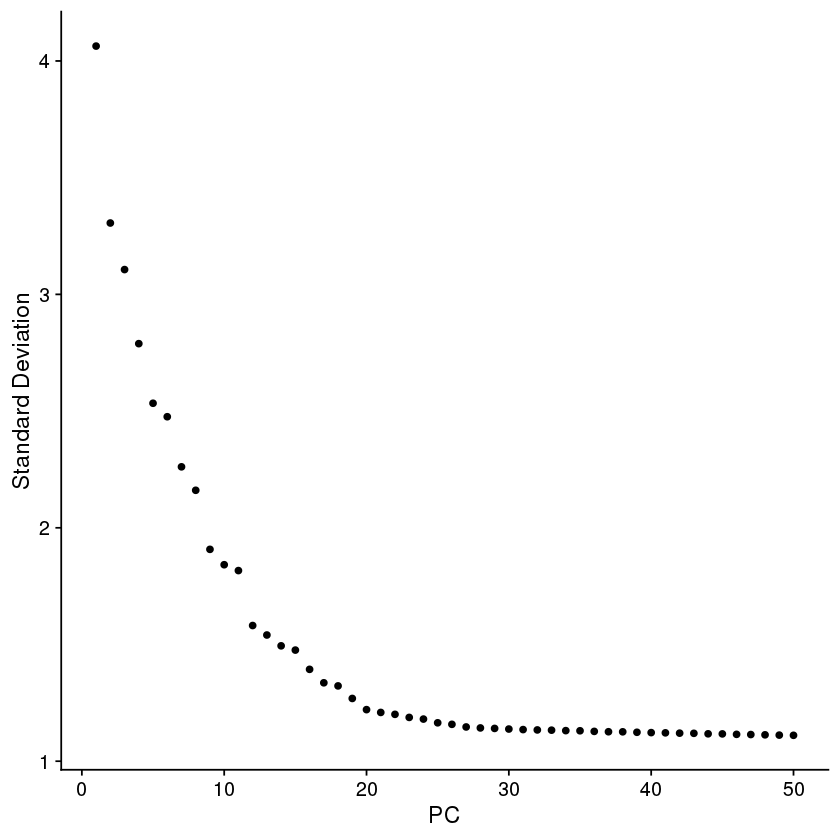

In [9]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj),npcs=50)
# Determine the ‘dimensionality’ of the dataset according to elbow plot
pdf(paste0(datasetName,"seurat.elbowplot.pdf"))
ElbowPlot(dataobj,ndim=50) 
dev.off()
ElbowPlot(dataobj,ndim=50) 

In [10]:
pcDim = 30 # set as 75 in this case 

# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)

Computing nearest neighbor graph

Computing SNN



In [11]:
dataobj$cell_cluster<-dataobj$CT

In [12]:
dataobj <- FindClusters(dataobj, resolution = 1, n.start = 5)
randIndex(dataobj$cell_cluster,dataobj$seurat_clusters)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 18302
Number of edges: 609945

Running Louvain algorithm...
Maximum modularity in 5 random starts: 0.8310
Number of communities: 13
Elapsed time: 1 seconds


ARI 
0.5578716

In [13]:
dataobj <- RunUMAP(dataobj,dims=1:pcDim)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
17:11:47 UMAP embedding parameters a = 0.9922 b = 1.112

17:11:47 Read 18302 rows and found 30 numeric columns

17:11:47 Using Annoy for neighbor search, n_neighbors = 30

17:11:47 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

17:11:53 Writing NN index file to temp file /tmp/RtmpUVR80h/file318718b75c13

17:11:53 Searching Annoy index using 1 thread, search_k = 3000

17:12:00 Annoy recall = 100%

17:12:00 Commencing smooth kNN distance calibration using 1 thread

17:12:02 Initializing f

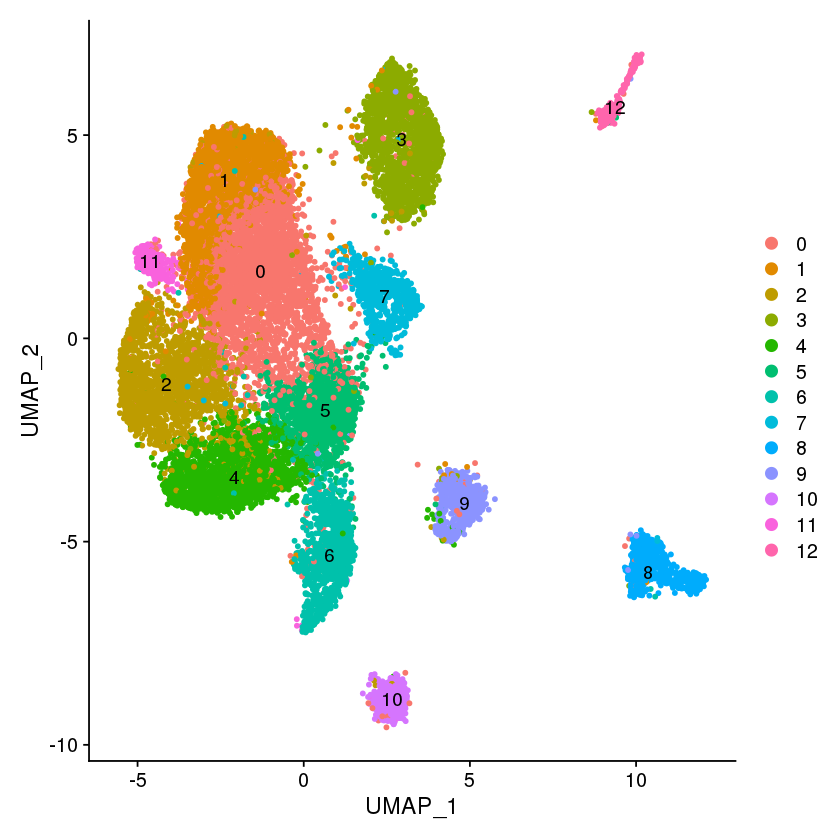

In [14]:
p_umap=DimPlot(dataobj,label = TRUE, pt.size=1)
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)
p_umap

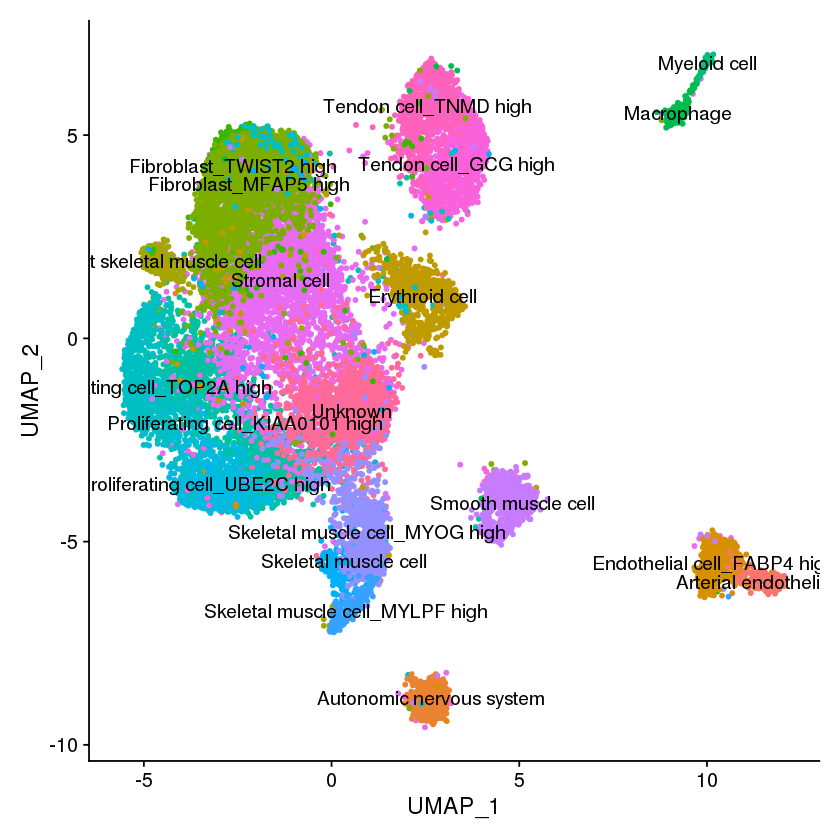

In [15]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = T, group.by = "cell_cluster", pt.size=1)+NoLegend()
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)
p_umap2

In [20]:
unique(dataobj$cell_cluster)

[1] Proliferating cell_KIAA0101 high Stromal cell                    
 [3] Unknown                          Proliferating cell_UBE2C high   
 [5] Autonomic nervous system         Tendon cell_GCG high            
 [7] Tendon cell_TNMD high            Fast skeletal muscle cell       
 [9] Fibroblast_TWIST2 high           Fibroblast_MFAP5 high           
[11] Skeletal muscle cell             Skeletal muscle cell_MYOG high  
[13] Endothelial cell_FABP4 high      Erythroid cell                  
[15] Proliferating cell_TOP2A high    Smooth muscle cell              
[17] Macrophage                       Skeletal muscle cell_MYLPF high 
[19] Arterial endothelial cell        Myeloid cell                    
20 Levels: Arterial endothelial cell ... Unknown

In [31]:
new.cluster.ids <- c("Muscle-Connective tissue-Stromal cell-LUM", 
                     "Muscle-Connective tissue-Fibroblast-COL1A1", 
                     "Muscle-Proliferating T cell-UBE2C",
                     "Muscle-Muscle tissue-Tendon cell-GAS2",
                     "Muscle-Proliferating T cell-UBE2C",
                     "Muscle-Neuron tissue-Neuron-C1QTNF3",
                     "Muscle-Muscle tissue-Skeletal muscle cell-ACTC1",
                     "Muscle-Connective tissue-Erythrocyte-HBG2", 
                     "Muscle-Epithelial tissue-Endothelial cell-FABP4",
                     "Muscle-Muscle tissue-Smooth muscle cell-ACTA2",
                     "Muscle-Neuron tissue-Autonomic nervous system-S100B",
                     "Muscle-Muscle tissue-Skeletal muscle cell-ACTC1",
                     "Muscle-Connective tissue-Macrophage-HLA-DRA"
                    )

In [32]:
subset(dataobj.markers,cluster=='12')
# subset(dataobj.markers,gene=='NUPR1')

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
CD74,0,3.104252,0.431,0.006,0,12,CD74
LYZ,0,2.912036,0.225,0.002,0,12,LYZ
HLA-DRA,0,2.554125,0.333,0.002,0,12,HLA-DRA
AIF1,0,2.449244,0.577,0.013,0,12,AIF1
LYVE1,0,2.258855,0.419,0.004,0,12,LYVE1
TYROBP,0,2.249178,0.487,0.002,0,12,TYROBP
F13A1,0,2.152911,0.363,0.002,0,12,F13A1
CD14,0,2.030694,0.363,0.002,0,12,CD14
CSF1R,0,1.919223,0.390,0.001,0,12,CSF1R


In [33]:
names(x = new.cluster.ids) <- levels(x = dataobj)
annodataobj <- RenameIdents(object = dataobj, new.cluster.ids)

In [35]:
rr2 <- RunUMAP(annodataobj,dims=1:pcDim)

21:07:37 UMAP embedding parameters a = 0.9922 b = 1.112

21:07:37 Read 18302 rows and found 30 numeric columns

21:07:37 Using Annoy for neighbor search, n_neighbors = 30

21:07:37 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

21:07:42 Writing NN index file to temp file /tmp/RtmpUVR80h/file3187357e5322

21:07:42 Searching Annoy index using 1 thread, search_k = 3000

21:07:49 Annoy recall = 100%

21:07:50 Commencing smooth kNN distance calibration using 1 thread

21:07:52 Initializing from normalized Laplacian + noise

21:07:52 Commencing optimization for 200 epochs, with 836304 positive edges

21:08:19 Optimization finished



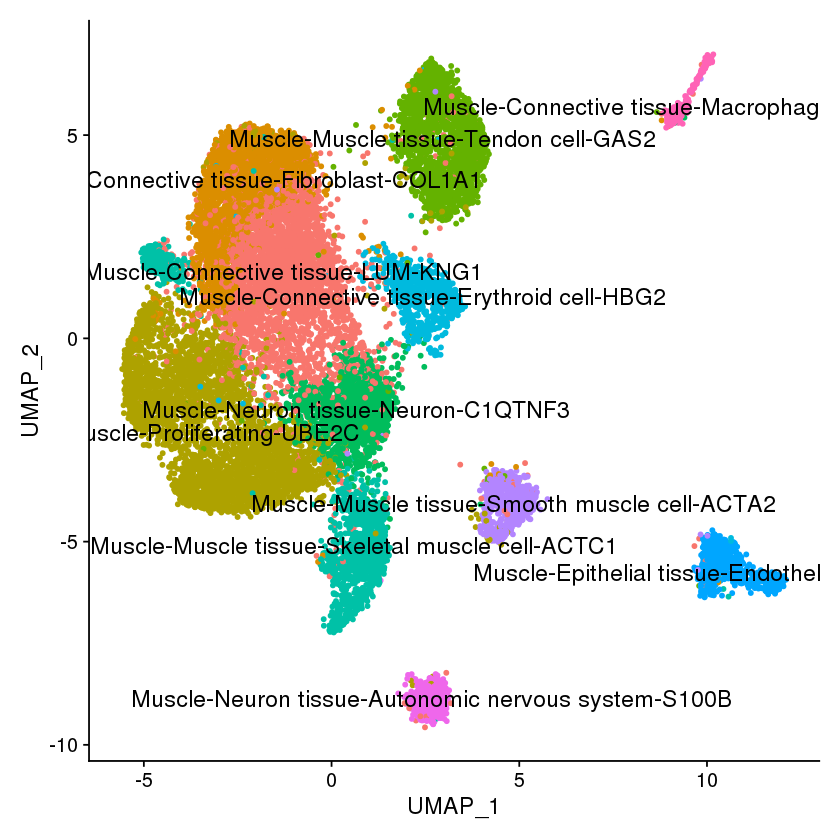

In [36]:
p_umap4 <- UMAPPlot(rr2,label = T, pt.size=1,label.size=5)+NoLegend()
# LabelClusters(plot = p_umap4, id = 'ident', color = 'white')
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap4, width = 25, height = 15)
p_umap4

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


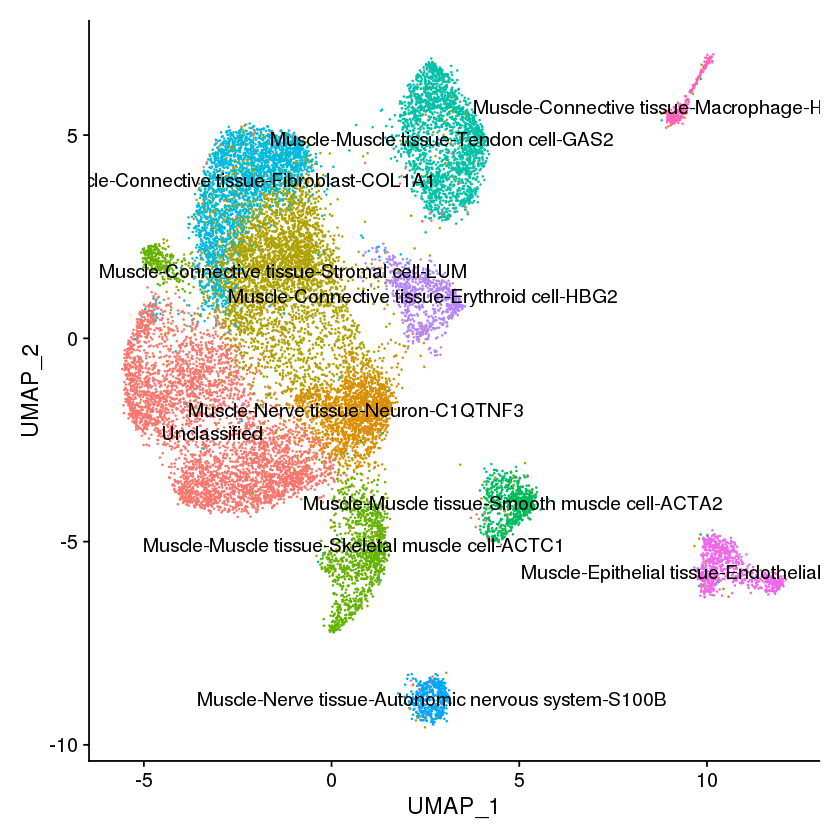

In [7]:
dataobj$hcadv1name = dataobj.dbupload_v1$hcad_name
Idents(dataobj) = dataobj$hcadv1name
UMAPPlot(dataobj,label=T)+NoLegend()

In [9]:
FindMarkers(dataobj,ident.1='Unclassified', only.pos = TRUE)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
UBE2C,0.000000e+00,1.7444515,0.497,0.074,0.000000e+00
PTTG1,0.000000e+00,1.5214665,0.446,0.077,0.000000e+00
HMGB2,0.000000e+00,1.4654826,0.780,0.253,0.000000e+00
CDK1,0.000000e+00,1.3130106,0.341,0.050,0.000000e+00
TOP2A,0.000000e+00,1.3103698,0.301,0.042,0.000000e+00
PCLAF,0.000000e+00,1.2985121,0.648,0.182,0.000000e+00
CKS2,0.000000e+00,1.2910144,0.410,0.093,0.000000e+00
H2AZ1,0.000000e+00,1.2786050,0.854,0.348,0.000000e+00
NUSAP1,0.000000e+00,1.2170588,0.292,0.038,0.000000e+00


In [16]:
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12



In [49]:
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)
# 
dataobj<-AddMetaData(dataobj, metadata =as.character(dataobj$seurat_clusters),col.name='hcad.label') 

write.table(cbind(colnames(dataobj), dataobj$hcad.label), file = paste0(datasetName,"_annotation.hcad.tsv"), sep = "\t", quote = F, row.names = F, col.names = c('cell_ID','cell_cluster'))

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [3]:
dataobj <- readRDS(file = paste0(datasetName,".seuratobj.rds"))

In [37]:

write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)
# 
dataobj<-AddMetaData(dataobj, metadata =as.character(annodataobj@active.ident),col.name='hcad.label') 

write.table(cbind(colnames(dataobj), dataobj$hcad.label), file = paste0(datasetName,"_annotation.hcad.tsv"), sep = "\t", quote = F, row.names = F, col.names = c('cell_ID','cell_cluster'))

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [12]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [4]:
head(dataobj[[]],3)

,orig.ident,nCount_RNA,nFeature_RNA,cluster,Tissue,CT,cell_cluster,RNA_snn_res.1,seurat_clusters,hcad.label
,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>
FetalMuscle_1.GGTACACGTATTGCTCAA,FetalMuscle,1085.547,355,Fetal-Muscle1_6,Fetal-Muscle1,Proliferating cell_KIAA0101 high,Proliferating cell_KIAA0101 high,4,4,Muscle-Proliferating-UBE2C
FetalMuscle_1.CCGCTACCGCTATGAAGC,FetalMuscle,1456.678,597,Fetal-Muscle1_6,Fetal-Muscle1,Proliferating cell_KIAA0101 high,Proliferating cell_KIAA0101 high,2,2,Muscle-Proliferating-UBE2C
FetalMuscle_1.GCTCAAGGGCGATTCATA,FetalMuscle,1473.658,602,Fetal-Muscle1_6,Fetal-Muscle1,Proliferating cell_KIAA0101 high,Proliferating cell_KIAA0101 high,2,2,Muscle-Proliferating-UBE2C


In [8]:
# ncol(result_data_out
# print(levels(dataobj$sample_status))
dataobj$donor_age    <- 'GW12'
dataobj$donor_ID <- 'NA'
dataobj$donor_gender <- "Male"

In [9]:
levels(dataobj$donor_age) <- c('GW11')

In [10]:
dataobj.dbupload_v1 <- CreateSeuratObject(dataobj.dbupload_v1@assays$RNA@data)
# dataobj.dbupload_v1 <- NormalizeData(dataobj.dbupload_v1, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj.dbupload_v1[['orig.ident']] <- NULL
dataobj.dbupload_v1[['nCount_RNA']] <- NULL
dataobj.dbupload_v1[['nFeature_RNA']] <- NULL
dataobj.dbupload_v1$user_id <- 1
dataobj.dbupload_v1$study_id<-"10.1038/s41586-020-2157-4"
dataobj.dbupload_v1$cell_id <- colnames(dataobj.dbupload_v1@assays$RNA@data)
dataobj.dbupload_v1$organ<-"Muscle"
dataobj.dbupload_v1$region<-"NA"
dataobj.dbupload_v1$subregion<-"NA"
dataobj.dbupload_v1$seq_tech<-"Microwell-seq"
dataobj.dbupload_v1$sample_status<-"Healthy"
dataobj.dbupload_v1$donor_id<-dataobj$donor_ID
dataobj.dbupload_v1$donor_gender<-dataobj$donor_gender
dataobj.dbupload_v1$donor_age<- dataobj$donor_age
dataobj.dbupload_v1$original_name<-dataobj$cell_cluster
dataobj.dbupload_v1$cl_name<-"NA"
dataobj.dbupload_v1$hcad_name<-dataobj$hcad.label

In [11]:
dataobj.dbupload_v1$original_name<-as.character(dataobj.dbupload_v1$original_name)
dataobj.dbupload_v1$donor_id<-as.character(dataobj.dbupload_v1$donor_id)
dataobj.dbupload_v1$donor_gender<-as.character(dataobj.dbupload_v1$donor_gender)
dataobj.dbupload_v1$donor_age<- sub("Y","yr",dataobj.dbupload_v1$donor_age)


In [7]:
saveRDS(dataobj.dbupload_v1, file = paste0(datasetName,".seuratobj.dbupload_v1.rds"))

In [ ]:
ncol(dataobj.dbupload_v1@meta.data)
colnames(dataobj.dbupload_v1@meta.data)

In [ ]:
dataobj.dbupload_v1

In [ ]:
head(dataobj.dbupload_v1[[]],3)

In [13]:
dataobj.dbupload_v1$hcad_name<- sub("Muscle-Connective tissue-LUM-KNG1","Muscle-Connective tissue-Stromal cell-LUM-KNG1",dataobj.dbupload_v1$hcad_name)
dataobj.dbupload_v1$hcad_name<- sub("Muscle-Proliferating-UBE2C","Unknown",dataobj.dbupload_v1$hcad_name)
dataobj.dbupload_v1$hcad_name<- sub("Neuron tissue","Nerve tissue",dataobj.dbupload_v1$hcad_name)

In [3]:
dataobj.dbupload_v1 <- readRDS(file = paste0(datasetName,".seuratobj.dbupload_v1.rds"))